###  STRUCT Without Swapping

In [894]:
import numpy as np
import math
from math import log
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def convert_from_scikit_learn_to_dic_ite(node_index,is_leaves, children_left,children_right,feature,threshold,value,labels,C):
        
        a = is_leaves[0]
        b = feature[0]
        c = threshold[0]
        if (a):
            d = value[0]  #datapoints of each class in the node
            d2 = np.squeeze(d/np.sum(d))
            d3 = np.zeros(C)
            d3[labels] = d2
            e = labels[np.argmax(d2)]
            return {'splitting_feature' : None,
            'left' : None,
            'right' : None,
            'is_leaf': True,
            'prediction': e,
            'labels_distribution':d3}
    
        else:
            left = children_left[0]-node_index[0]
            if(left==-1):
                left_tree = None
            else:
                left_tree = convert_from_scikit_learn_to_dic_ite(node_index[left:],is_leaves[left:], children_left[left:],children_right[left:],feature[left:],threshold[left:],value[left:],labels,C)
            right = children_right[0]-node_index[0]
            if(right==-1):
                right_tree = None
            else:
                right_tree = convert_from_scikit_learn_to_dic_ite(node_index[right:],is_leaves[right:], children_left[right:],children_right[right:],feature[right:],threshold[right:],value[right:],labels,C)
            return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': b,
            'threshold'        : c,
            'left'             : left_tree, 
            'right'            : right_tree,
            'labels_distribution': None}


def convert_from_scikit_learn_to_dic(tree,threshold,C,Q):
    # C is the size of the whole labels
    # labels are the labels that are used in the this tree
    labels = range(0,C,1)
    n_nodes = tree.tree_.node_count
    #n_nodes = subset.shape[0]
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    feature = tree.tree_.feature
    node_index = np.array(range(0,n_nodes))
    Val = Q   #datapoints in node
# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
    node_depth = np.zeros(shape=n_nodes)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1
    # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True
    
    return convert_from_scikit_learn_to_dic_ite(node_index,is_leaves, children_left,children_right,feature,threshold,Val,labels,C)

#def TransferToSKLsequence(T):
#    children_left = []
#    children_right = []
#    for i in range(len(T)):
    


def kl (p,q): # Kullback-libler divegence
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)
    return np.sum(np.where(p != 0,p * np.log10((p / q)), 0))

def jsd(p,q): # Symmetric Kullback-libler divergence
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)
    m = (p+q)/2
    return (kl(p,m)+kl(m,q))/2

def infogain(yleft,len_left,yright,len_right):
    yparent = (yleft+yright)/2
    N = len_left+len_right
    #compute information gain
    I = entropy(yparent) -( (len_left/N)*entropy(yleft) + (len_right/N)*entropy(yright) )   
    return I

#entropy for multiple classes
def entropy(y):
    y1 = y[y!=0]
    H = -(y1*np.log10(y1)).sum()
    return H 

def partition(Xtarget,ytarget,index_of_data,feature,C,threshold): # divide the data to the left and rightbased on the threshold
    left = index_of_data[Xtarget[index_of_data,feature]<threshold]
    if(len(left)==0):
        left = index_of_data[Xtarget[index_of_data,feature]<=threshold]
    labels_left = ytarget[left]
    qL = np.bincount(labels_left)
    right = index_of_data[Xtarget[index_of_data,feature]>=threshold]
    labels_right = ytarget[right]
    qR = np.bincount(labels_right)
    qR = np.append(qR,np.zeros(np.max([C-qR.shape[0],0])))
    qL = np.append(qL,np.zeros(np.max([C-qL.shape[0],0]))) 
    qL = qL/qL.sum()
    qR = qR/qR.sum()
    return [qL,left,qR,right]

def dg(Sleft,lenleft,Sright,lenright,QL,QR): # DG function as in the paper    
    return 1-(lenleft/(lenleft+lenright))*jsd(Sleft,QL)-(lenright/(lenleft+lenright))*jsd(Sright,QR)
    
def threshold_selection(X,y,S,f,QL,QR,C,verbos): # finding the best threshold
    fvals = np.sort(X[S,f])
    num_data_points = len(fvals)
    N = 50
    Val  = np.array([])
    #Val_swap  = np.array([])
    Val_infogain = np.array([])
    if num_data_points > N-1: 
        I = range(0,num_data_points,np.floor(num_data_points/N).astype(int))
        fvals = fvals[I[1:-1]]
    for i in fvals:
        [Sleft, left, Sright, right] = partition(X,y,S,f,C,i)
        #fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
        #ax1.plot(QL)
        #ax1.set_title('QL')
        #ax2.plot(Sleft, color='r')
        #ax2.set_title('QprimeL')
        #ax3.plot(QR)
        #ax3.set_title('QR')
        #ax4.plot(Sright, color='r')
        #ax4.set_title('QprimeR')
        Val = np.append(Val,dg(Sleft,len(left),Sright,len(right),QL,QR))
        Val_infogain = np.append(Val_infogain,infogain(Sleft,len(left),Sright,len(right)))        #Val_swap = np.append(Val_swap,dg(Sleft,len(left),Sright,len(right),QR,QL)) # this is the divergence measure for each threshold split  
    if(verbos):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', sharey='row')
    #ax1.plot(Val)
    #ax1.set_title('DG')
    #ax2.plot(Val_infogain)
    #ax2.set_title('infogain')
        ax1.plot(fvals,Val)
        ax1.hold(True)
        ax1.plot(fvals,Val_infogain)
        ax1.hold(False)
        ax1.set_title('DG and Infogain')
    #plt.show()
    Val[np.isnan(Val)] = min(Val[~np.isnan(Val)])
    Val_infogain[np.isnan(Val_infogain)] = min(Val_infogain[~np.isnan(Val_infogain)])
    #Val_swap[np.isnan(Val_swap)] = min(Val_swap[~np.isnan(Val_swap)])
    th = fvals[np.argmax(Val)]
    th_infogain = fvals[np.argmax(Val_infogain)]
    if(len(S)<50):
        [ql, left, qr, right] = partition(X,y,S,f,C,th_infogain)
    else:
        [ql, left, qr, right] = partition(X,y,S,f,C,th)
    if(verbos):
        ax2.plot(ql)
        ax2.hold(True)
        ax2.plot(qr)
        ax2.hold(False)
        ax2.set_title('Dist Target Data')

        ax3.plot(QL)
        ax3.hold(True)
        ax3.plot(QR)
        ax3.hold(False)
        ax3.set_title('Dist Source Data')
    return [th, ql, qr, left, right]

def classify(tree, x):   
    # if the node is a leaf node.
    if tree['is_leaf']:
        return tree['labels_distribution'] 
    else:
        # split on feature.
        val_split_feature = x[tree['splitting_feature']]
        if val_split_feature < tree['threshold']:
            return classify(tree['left'], x)
        else:
            return classify(tree['right'],x)

def forest_posterior(RF,x):

    T = len(RF)  #the number of trees 

    #infer the number of classes
    P0 = classify(RF[0],x)
    C = len(P0)
    
    Pt = np.zeros((T,C)) #matrix of posteriors from each tree (T x Nclasses)
    Pt[0,:] = P0
    for t in range(len(RF))[1:]:
        Pt[t,:] = classify(RF[t],x) 
    return Pt

#classify input based on majority voting of each tree prediction
def forest_classify_majority(RF,x):
        Pt = forest_posterior(RF,x)
        Yt = np.argmax(Pt,axis=1)         
        C,unique_counts = np.unique(Yt,return_counts=True) #the id of classes and number of each
        return C[np.argmax(unique_counts)]   
    
#classify input by averaging posteriors 
def forest_classify_ensemble(RF,x):
    Pt = forest_posterior(RF,x)
    Pforest = Pt.mean(axis=0)
    ypred = np.argmax(Pt.mean(axis=0))
    return ypred

def evaluate_classification_error(RF, X, y, method = None):  
    # Apply the forest_classify(RF, x) to each row in your data
    if method == None:
        ypred = map(lambda x: forest_classify_ensemble(RF,x), X)
        # Once you've made the predictions, calculate the classification error and return it
        mistakes = sum(ypred != y)
        error = mistakes/len(y)
    return error

def value_for_all(estimator,N):
    from scipy.sparse import csr_matrix
    ch_left = estimator.tree_.children_left
    ch_right = estimator.tree_.children_right
    (cl,) = np.where(ch_left!=-1)
    (cr,) = np.where(ch_right!=-1)
    cap = estimator.tree_.capacity
    dis_node = np.zeros((cap,estimator.tree_.n_classes))
    A = np.zeros([cap,cap])
    D = A
    A = csr_matrix(A)
    A[cl,ch_left[cl]] = 1
    A[cr,ch_right[cr]] = 1
    B = A
    C = B
    while(C.sum()!=0):
        C = A*C
        B = B + C
    I,J = B.nonzero()
    D[I,J] = 1
    (I,) = np.where(ch_left==-1)
    dis_node[I,:] = np.squeeze(estimator.tree_.value[I])
    for i in I:
        dis_node[i,:] = dis_node[i,:]/dis_node[i,:].sum()
    (remain1,) = np.where(ch_left!=-1)
    for i in remain1:
        (I,) = np.where(D[i,:]==1)
        dis_node[i,:] = np.sum(np.squeeze(estimator.tree_.value[I]),axis = 0)
        dis_node[i,:] = dis_node[i,:]/dis_node[i,:].sum()
    Dis_node = np.zeros((cap,N))
    Dis_node[:,estimator.classes_.astype(int)] = dis_node
    return Dis_node
    
def STRUCT(Xsource,ysource,Xtarget,ytarget,C,verbos = False):
    # Assumption: ysource has all the labels of the problem 
    #estimator = DecisionTreeClassifier(max_features='sqrt',random_state=0,max_depth=2)
    Estimator = RandomForestClassifier(max_features='sqrt',random_state=0,max_depth=2,n_estimators=1)
    Estimator = Estimator.fit(Xsource, ysource)
    RF = []
    for rf in range(Estimator.n_estimators):
        estimator = Estimator.estimators_[rf]
        dis_node = value_for_all(estimator,C)
        P = list(np.zeros(estimator.tree_.capacity))
        P[0] = range(len(ytarget))
        Q = list(np.zeros(estimator.tree_.capacity))
        Q[0] = dis_node[0,:]
        thresh = np.zeros(estimator.tree_.capacity)
        remain = [0]
        subset = []
        while(len(remain)!=0):
            i = remain[0]
            LF = estimator.tree_.children_left
            LR = estimator.tree_.children_right
            index_left = LF[i]
            index_right = LR[i]
            if(index_left!=-1):
                QL = dis_node[index_left,:]
                QR = dis_node[index_right,:]
                f = estimator.tree_.feature[i]
                [th, ql, qr, left, right] = threshold_selection(Xtarget,ytarget,np.array(P[i]),f,QL,QR,C,verbos)
                thresh[i] = th
                P[index_left] = left
                P[index_right] = right
                Q[index_left] = ql
                Q[index_right] = qr
                if(len(left)!=0):
                    remain = np.append(remain,index_left)
                if(len(right)!=0):
                    remain = np.append(remain,index_right)
                if(len(left)>10000 and len(right)>10000):
                    subset.append(i)
                    print i
            remain = remain[1:]
        lf =  LF[subset]
        lr =  LR[subset]
        subset = np.append(subset,lf)
        subset = np.append(subset,lr)
        print subset
        ST = convert_from_scikit_learn_to_dic(estimator,thresh,C,Q)
        RF.append(ST)
    return RF

0
[0 1 4]


/Users/RoozbehFarhoudi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:237: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


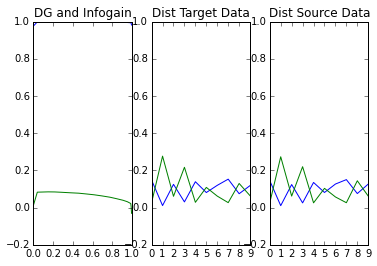

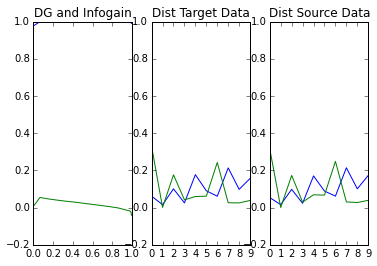

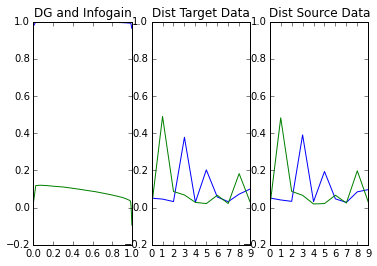

In [895]:
ST = STRUCT(Xsource,ysource,Xtarget,ytarget,10,verbos = True)
#ST = STRUCT(Xtrain[:,:],ytrain[:],Xtest[:,:],ytest[:],10,verbos = True)

In [786]:
subset = []
i=0
print type(i)
print type(subset)
subset.append(i)
print type(subset)
subset

<type 'int'>
<type 'list'>
<type 'list'>


[0]

In [ ]:
np.any([[1,2] ,[1]])


In [644]:
evaluate_classification_error(ST, Xtest, ytest, method = None)

0.48499999999999999

In [569]:
Estimator = RandomForestClassifier(max_features='sqrt',random_state=0,max_depth=1,n_estimators=1)
Estimator = Estimator.fit(Xtrain[minus,:],ytrain[minus])
estimator = Estimator.estimators_[0]
E = value_for_all(estimator,10)
print E

[[ 0.19291676  0.21934517  0.1954847   0.2029032   0.18935017  0.          0.
   0.          0.          0.        ]
 [ 0.31853718  0.02687859  0.27602248  0.06719649  0.31136525  0.          0.
   0.          0.          0.        ]
 [ 0.03813391  0.45649232  0.0962503   0.37011384  0.03900963  0.          0.
   0.          0.          0.        ]]


/Users/RoozbehFarhoudi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:200: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


3.35808393322e-05
6.23178665997e-05
5.19173518474e-05
0.000110298670711
0.000104176318478
7.67883481935e-05
9.5141696959e-05
6.69922157116e-05
0.000144483564029
0.00021686193831
0.000153402897892
0.00132923468538
5.64420875163e-05
0.000260480145652


/Users/RoozbehFarhoudi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:201: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


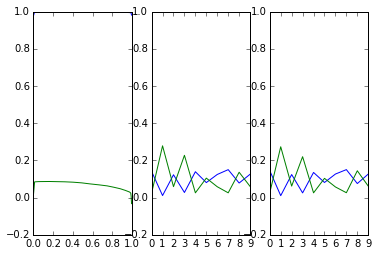

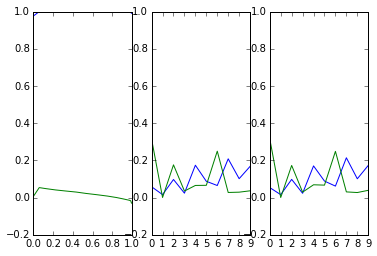

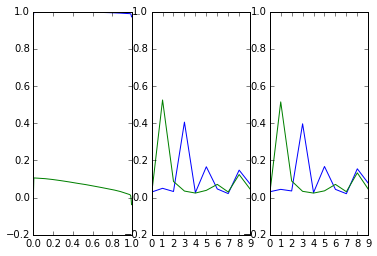

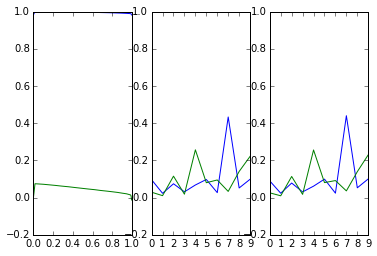

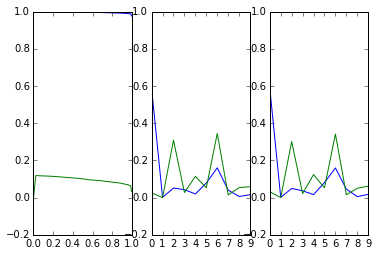

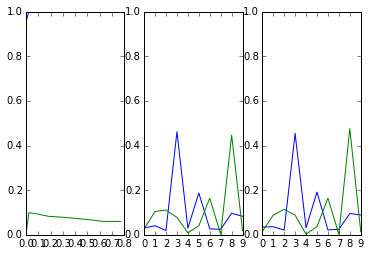

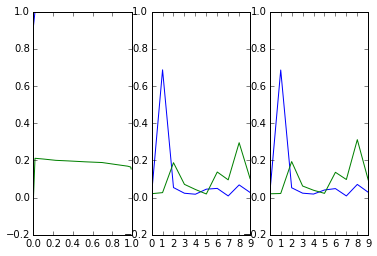

In [527]:
(I,) = np.where()
ST = STRUCT(Xsource,ysource,Xsource[:,:],ysource[:],10)
#print ST

In [495]:
estimator = RandomForestClassifier(max_features='sqrt',random_state=0,max_depth=2)
#estimator = RandonForestClassifier(max_features='sqrt',random_state=0,max_depth=2)
estimator = estimator.fit(Xsource, ysource)
estimator.n_estimators

10

In [1]:
from sklearn.datasets import make_classification
from sklearn.cross_validation import train_test_split
import numpy as np
from __future__ import division
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../MNIST_data/", one_hot=False)
Xtrain = mnist.train.images
Xtest = mnist.test.images
ytrain = mnist.train.labels
ytest = mnist.test.labels
Xsource, Xtarget, ysource, ytarget = train_test_split(Xtrain, ytrain, test_size=0.5)
print Xtrain.shape
print Xtest.shape
print Xsource.shape
print Xtarget.shape
XT1,XT2,yT1,yT2 = train_test_split(Xtarget,ytarget,test_size=0.5)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz
(55000, 784)
(10000, 784)
(27500, 784)
(27500, 784)


In [460]:
a = np.array([ 0.03435023,  0.24237329,  0.18984707,  0.15942029 , 0.05084474 , 0.04347826 ,0.06229482 , 0.10361118  ,0.0683001 ,  0.04548002])
infogain(a,30,a,50)

[ 0.03435023  0.24237329  0.18984707  0.15942029  0.05084474  0.04347826
  0.06229482  0.10361118  0.0683001   0.04548002]


0.0

In [ ]:
a = np.empty([2,2])
a[1,1] = -1
a= np.argmax(a)
print a